In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns


### Implementare regresie logistica cu bgd + plotare decision boundry + plotare cost 

In [ ]:
class LogisticRegressionBGD:
    def __init__(self, learning_rate=0.01, epochs=1000, batch_size=32):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.coef_ = None
        self.intercept_ = None
    
    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        if X.ndim == 1:
            X = X.reshape(-1, 1)
        X_with_bias = np.c_[np.ones((X.shape[0],)), X]

        # initializam weights cu valori aleatorii mici
        num_features = X_with_bias.shape[1]
        self.weights = np.random.randn(num_features) * 0.01

        n_samples = X_with_bias.shape[0]
        
        # lista pentru a stoca cost-ul pe fiecare epoca
        self.cost_history = []

        # antrenare pe epoci
        for epoch in range(self.epochs):
            # amestecam datele pentru fiecare epoca
            indices = np.random.permutation(n_samples)
            X_shuffled = X_with_bias[indices]
            y_shuffled = y[indices]
            
            epoch_cost = 0

            # Procesam fiecare batch
            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_samples)

                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # calculam predictiile pentru batch folosind sigmoid
                linear_model = X_batch.dot(self.weights)
                y_pred = self.sigmoid(linear_model)

                # calculam erorile
                errors = y_pred - y_batch

                # calculam gradientul si actualizam weights
                gradient = (1 / len(X_batch)) * X_batch.T.dot(errors)
                self.weights -= self.learning_rate * gradient
                
                # calculam costul pentru acest batch (cross-entropy loss)
                batch_cost = -np.mean(y_batch * np.log(y_pred + 1e-10) + 
                                     (1 - y_batch) * np.log(1 - y_pred + 1e-10))
                epoch_cost += batch_cost * len(X_batch) / n_samples
            
            # adaugam costul epocii in istoric
            self.cost_history.append(epoch_cost)
            
            # afisam progresul la fiecare 100 de epoci
            if (epoch + 1) % 100 == 0:
                print(f"Epoca {epoch + 1}/{self.epochs}, Cost: {epoch_cost:.4f}")

        # setam intercept_ si coef_ pentru compatibilitate cu sklearn
        self.intercept_ = self.weights[0]
        self.coef_ = self.weights[1:]

        return self
    
    def predict_proba(self, X):
        X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        X_with_bias = np.c_[np.ones((X.shape[0],)), X]
        return self.sigmoid(X_with_bias.dot(self.weights))
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def plot_cost_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.epochs + 1), self.cost_history, 'b-')
        plt.title('Evolutia functiei cost in timpul antrenarii')
        plt.xlabel('Epoca')
        plt.ylabel('Cost')
        plt.grid(True)
        plt.show()
    
    def plot_decision_boundary(self, X, y, feature_names=['Feature 1', 'Feature 2'], title="Frontiera de decizie"):
        if X.shape[1] != 2:
            raise ValueError("Aceasta functie poate fi folosita doar pentru date cu 2 caracteristici")
    
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
        Z = self.predict_proba(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
        plt.figure(figsize=(10, 8))
        contour = plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.4, cmap='bwr')

        scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=50, edgecolor='k')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(title)
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
        plt.legend(*scatter.legend_elements(), title="Clase")
        plt.grid(True)
        plt.show()

    

### Definirea coloanelor din data set + plotare tumori reale vs prezise +  plotare pentru decision boundry


In [69]:
# Definim structura setului de date WDBC conform documentației
wdbc_columns = [
    'id', 'diagnosis',
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean',
    'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se',
    'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se',
    'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
    'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst',
    'symmetry_worst', 'fractal_dimension_worst'
]

def plot_tumors_real_vs_predicted(X, y_real, y_pred, tumor_type=0, feature_names=['Feature 1', 'Feature 2'], title="Compararea tumorilor reale cu cele prezise"):
    # selectam tumorile reale si prezise de tipul dorit
    actual_tumor = (y_real == tumor_type)
    predicted_tumor = (y_pred == tumor_type)

    # cream graficul
    plt.figure(figsize=(10, 6))

    # tumori reale (puncte rosii)
    plt.scatter(X[actual_tumor, 0], 
                X[actual_tumor, 1],
                color='red', label=f'Tumori reale {["benigne", "maligne"][tumor_type]}', s=100, marker='o', edgecolor='k')

    # tumori prezise (X-uri albastre)
    plt.scatter(X[predicted_tumor, 0], 
                X[predicted_tumor, 1],
                color='blue', label=f'Tumori prezise {["benigne", "maligne"][tumor_type]}', s=100, marker='x')

    # setam titlul si etichetele
    plt.title(title, fontsize=16)
    plt.xlabel(feature_names[0], fontsize=12)
    plt.ylabel(feature_names[1], fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_decision_boundary_and_predictions(model, X, y, feature_names=['Feature 1', 'Feature 2'], title="Frontiera de decizie", point_to_predict=np.array([18, 10])):
    if X.shape[1] != 2:
            raise ValueError("Aceasta functie poate fi folosita doar pentru date cu 2 caracteristici")
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.4, cmap='bwr')

    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=50, edgecolor='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend(*scatter.legend_elements(), title="Clase")
    plt.grid(True)
    plt.show()
    
    prob = model.predict_proba([point_to_predict])[0][1]
    cls = model.predict([point_to_predict])[0]
    # afisare rezultat in consola
    print(f"Pentru o leziune cu {feature_names[0]}={point_to_predict[0]} și {feature_names[1]}={point_to_predict[1]}:")
    print(f"Probabilitatea de a fi malignă: {prob:.4f}")
    print(f"Clasificare: {'Malignă' if cls == 1 else 'Benignă'}")





Distributia claselor in setul nostru de exemple:
Benign: 357, Malign: 212

Statistici pentru caracteristicile selectate:
Raza medie: min=6.98, max=28.11, media=14.13, std=3.52
Textura medie: min=9.71, max=39.28, media=19.29, std=4.30
Epoca 100/1000, Cost: 0.2562
Epoca 200/1000, Cost: 0.2562
Epoca 300/1000, Cost: 0.2562
Epoca 400/1000, Cost: 0.2562
Epoca 500/1000, Cost: 0.2562
Epoca 600/1000, Cost: 0.2562
Epoca 700/1000, Cost: 0.2562
Epoca 800/1000, Cost: 0.2562
Epoca 900/1000, Cost: 0.2562
Epoca 1000/1000, Cost: 0.2562


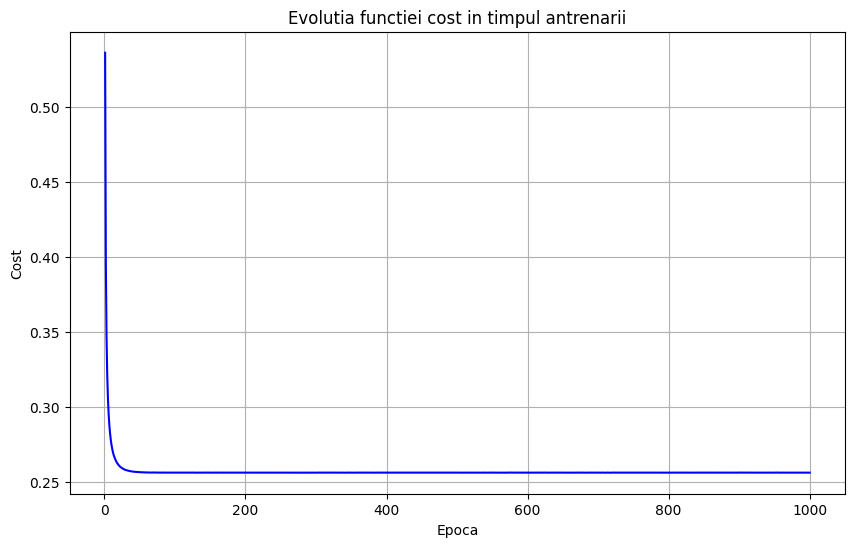

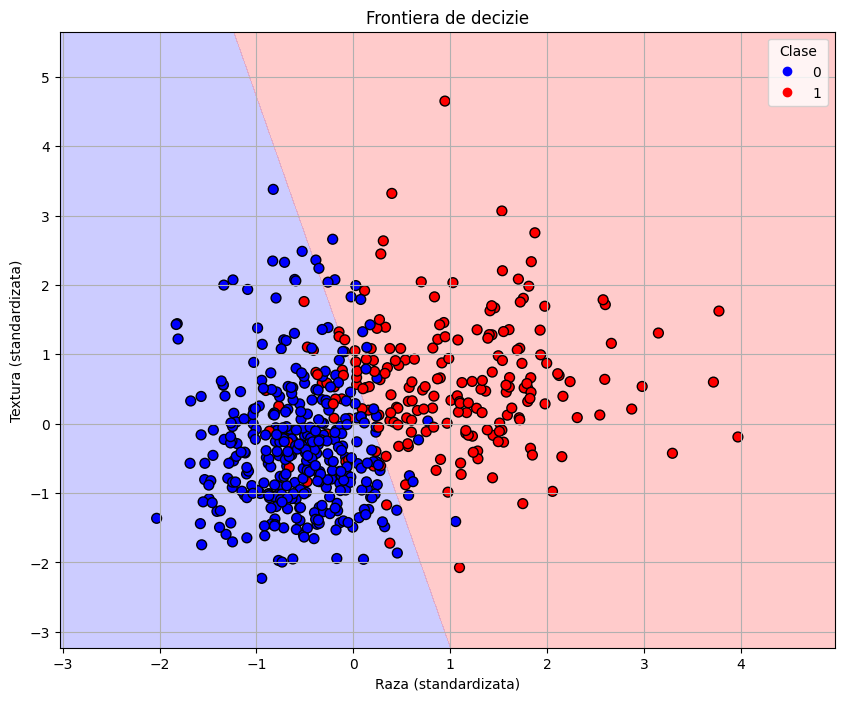


Pentru o leziune cu rază=18 și textură=10:
Probabilitatea de a fi malignă: 0.7960
Clasificare: Malignă


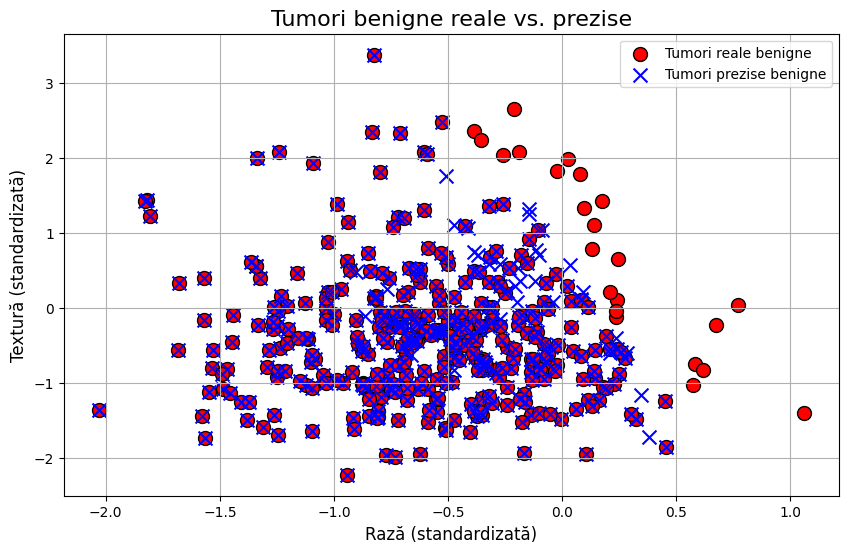

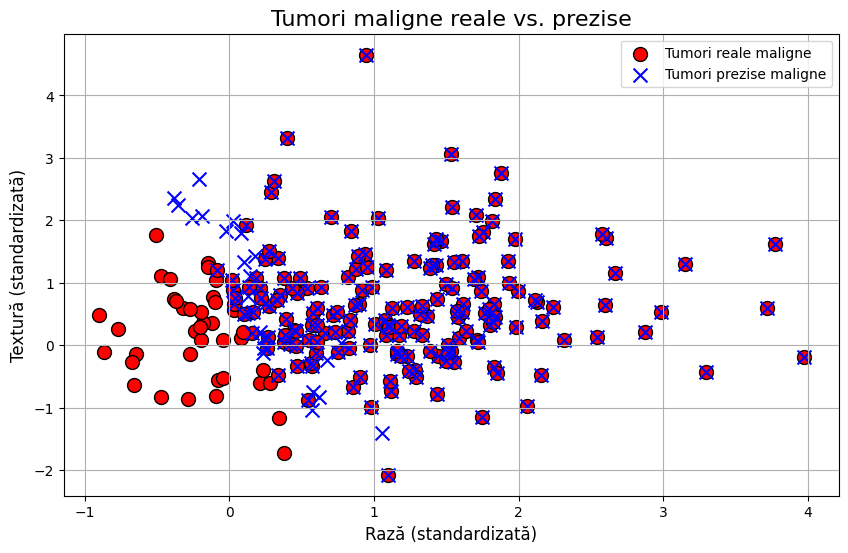


Ecuatia frontierei de decizie in spatiul original:
p(y=1) = sigmoid(-19.8407 + 1.0567 * rază + 0.2181 * textură)
Pentru p(y=1) = 0.5, frontiera este: -19.8407 + 1.0567 * rază + 0.2181 * textură = 0


In [36]:
data = pd.read_csv('./data/wdbc.data', header=None, names=wdbc_columns)

data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

print("\nDistributia claselor in setul nostru de exemple:")
print(f"Benign: {sum(data['diagnosis'] == 0)}, Malign: {sum(data['diagnosis'] == 1)}")

# Extragem caracteristicile de rază și textură (cele mai relevante pentru problema noastră)
X = data[['radius_mean', 'texture_mean']].values
y = data['diagnosis'].values

print("\nStatistici pentru caracteristicile selectate:")
print(f"Raza medie: min={X[:, 0].min():.2f}, max={X[:, 0].max():.2f}, media={X[:, 0].mean():.2f}, std={X[:, 0].std():.2f}")
print(f"Textura medie: min={X[:, 1].min():.2f}, max={X[:, 1].max():.2f}, media={X[:, 1].mean():.2f}, std={X[:, 1].std():.2f}")

# normalizăm datele
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# antrenam modelul
model = LogisticRegressionBGD(learning_rate=0.01, epochs=1000, batch_size=2)  # Batch size mic pentru setul nostru mic
model.fit(X_scaled, y)

# afisam evolutia costului
model.plot_cost_history()

# afisam frontiera de decizie pe datele disponibile
model.plot_decision_boundary(X_scaled, y, 
                           feature_names=['Raza (standardizata)', 'Textura (standardizata)'],
                           title="Frontiera de decizie")

# predictie pentru cazul specific: raza=18 și textura=10
sample = np.array([[18, 10]])
sample_scaled = scaler.transform(sample)

# Facem predicția
prediction_prob = model.predict_proba(sample_scaled)[0]
prediction = model.predict(sample_scaled)[0]


print(f"\nPentru o leziune cu rază=18 și textură=10:")
print(f"Probabilitatea de a fi malignă: {prediction_prob:.4f}")
print(f"Clasificare: {'Malignă' if prediction == 1 else 'Benignă'}")

# tumorile benigne reale vs. prezise
plot_tumors_real_vs_predicted(X_scaled, y, model.predict(X_scaled), tumor_type=0, feature_names=['Rază (standardizată)', 'Textură (standardizată)'], title="Tumori benigne reale vs. prezise")

# tumorile maligne reale vs. prezise
plot_tumors_real_vs_predicted(X_scaled, y, model.predict(X_scaled), tumor_type=1, feature_names=['Rază (standardizată)', 'Textură (standardizată)'], title="Tumori maligne reale vs. prezise")


# determinam coeficientii in spatiul original
coef_original = model.coef_ / scaler.scale_
intercept_original = model.intercept_ - np.dot(coef_original, scaler.mean_)

print(f"\nEcuatia frontierei de decizie in spatiul original:")
print(f"p(y=1) = sigmoid({intercept_original:.4f} + {coef_original[0]:.4f} * rază + {coef_original[1]:.4f} * textură)")
print(f"Pentru p(y=1) = 0.5, frontiera este: {intercept_original:.4f} + {coef_original[0]:.4f} * rază + {coef_original[1]:.4f} * textură = 0")


Acuratete: 0.8910369068541301
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       357
           1       0.89      0.81      0.85       212

    accuracy                           0.89       569
   macro avg       0.89      0.87      0.88       569
weighted avg       0.89      0.89      0.89       569



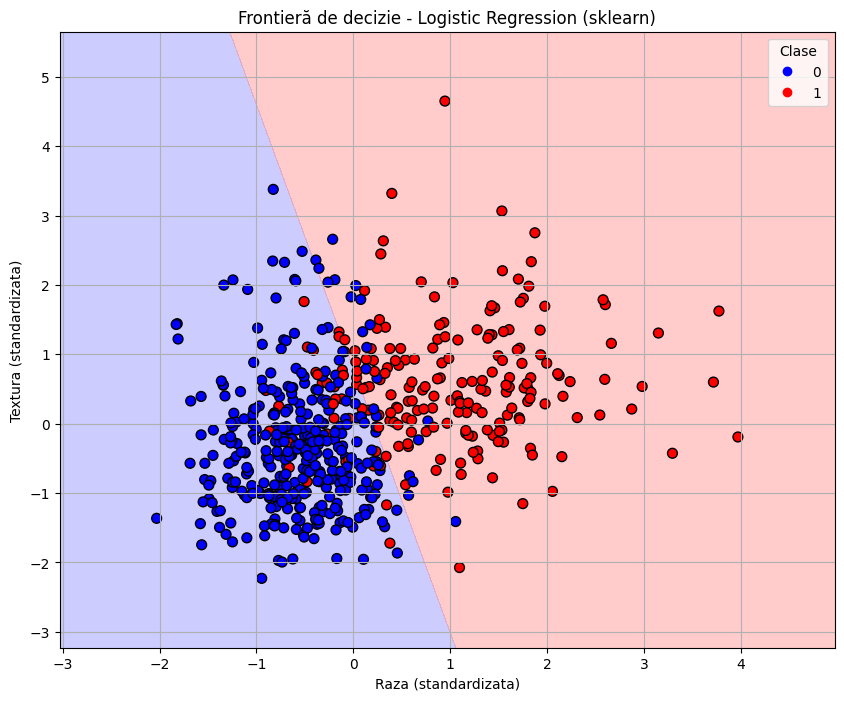

Pentru o leziune cu Raza (standardizata)=18 și Textura (standardizata)=10:
Probabilitatea de a fi malignă: 1.0000
Clasificare: Malignă


In [70]:
# Logistic Regression model
clf = LogisticRegression()
clf.fit(X_scaled, y)

# Predictii
y_pred = clf.predict(X_scaled)
print("Acuratete:", accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

plot_decision_boundary_and_predictions(
    clf, 
    X_scaled, 
    y, 
    feature_names=['Raza (standardizata)', 'Textura (standardizata)'], 
    title='Frontieră de decizie - Logistic Regression (sklearn)'
)